In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import os

from kan import KAN

print("Using PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("Using GPU, device name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("No CUDA found, using CPU instead.")
    device = torch.device("cpu")

Using PyTorch version: 2.3.0
No CUDA found, using CPU instead.


In [31]:
batch_size = 512
epochs = 500
data_dir = "./data"
print("data_dir =", data_dir)

train_dataset = datasets.MNIST(
    f"{data_dir}", train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(
    f"{data_dir}", train=False, download=True, transform=ToTensor()
)

data_dir = ./data


In [32]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    # Define convolutional layers
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Input channel=1 (grayscale), output channels=6, kernel size=5
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel size 2 and stride 2
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Input channels=6 (from prev layer), output channels=16, kernel size=5

  def forward(self, x):
    # Apply convolutions and pooling
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    return x

dsize = 10000

mean = torch.mean(train_dataset.data[:dsize].to(torch.float32))
std = torch.std(train_dataset.data[:dsize].to(torch.float32))
print(f"mean = {mean}, std = {std}")

model = FeatureExtractor()

dataset = {}
dataset["train_input"] = (
    torch.flatten(
        model(((train_dataset.data[:dsize] - mean) / std).unsqueeze(1)).squeeze(1),
        start_dim=1,
    )
    .long()
    .to(device)
)
dataset["test_input"] = (
    torch.flatten(
        model(((test_dataset.data[:dsize] - mean) / std).unsqueeze(1)).squeeze(1),
        start_dim=1,
    )
    .long()
    .to(device)
)
    
dataset["train_label"] = train_dataset.targets[:dsize].long().to(device)
dataset["test_label"] = test_dataset.targets[:dsize].long().to(device)

print("Train input shape:", dataset["train_input"].shape)
print("Test input shape:", dataset["test_input"].shape)
print("Train label shape:", dataset["train_label"].shape)
print("Test label shape:", dataset["test_label"].shape)

mean = 33.43706512451172, std = 78.71813201904297
Train input shape: torch.Size([10000, 256])
Test input shape: torch.Size([10000, 256])
Train label shape: torch.Size([10000])
Test label shape: torch.Size([10000])


train loss: 9.62e-01 | test loss: 1.01e+00 | reg: 1.04e+04 : 100%|█| 500/500 [10:24<00:00,  1.25s/it


Test accuracy: 66.76%


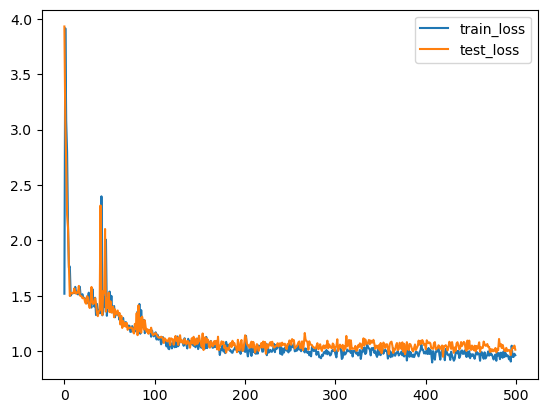

In [36]:
model = KAN(width=[dataset["train_input"].shape[1], 15, 10], grid=10, k=4)

results = model.train(
    dataset,
    opt="Adam",
    steps=epochs,
    lr=0.05,
    batch=batch_size,
    loss_fn=torch.nn.CrossEntropyLoss(),
)
torch.save(model.state_dict(), "kan.pth")

model.load_state_dict(torch.load("kan.pth"))
def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy


acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")

plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["test_loss"], label="test_loss")
plt.legend()

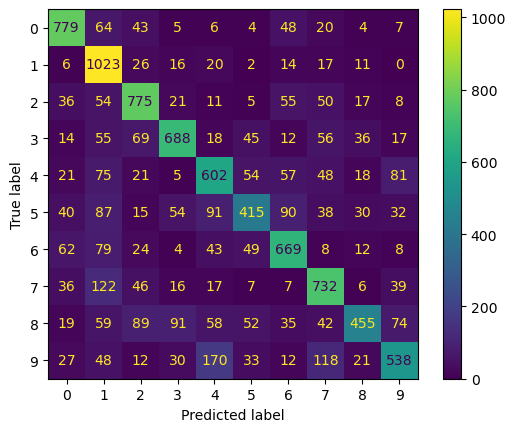

In [37]:
test_predictions = np.argmax(model(dataset["test_input"]).detach().numpy(),axis=1)
test_labels = dataset["test_label"]

labels_ = [i for i in range(10)]
cm = confusion_matrix(test_labels, test_predictions, labels=labels_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_)
disp.plot()
plt.show()
